In [26]:
# data was accessed from kaggle at the following link on 3-28-25
# https://www.kaggle.com/datasets/rtatman/188-million-us-wildfires
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, RocCurveDisplay, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestRegressor

os.chdir("c:/Users/AVILA/OneDrive/Documents/GitHub/Forest-fire-project")
df = pd.read_csv("fires_data.csv")

C:\Users\AVILA\AppData\Local\Temp\ipykernel_15952\376641788.py:14: DtypeWarning: Columns (8,10,11,12,13,14,15,16,17,18,35,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("fires_data.csv")


ok so we have the id for the fire, the fire name, the year of the fire, the date and time the fire was discovered, the cause of the fire, location of the fire, fire size, and the state that the fire occurred in. 

what if we did just, using the state, cause, and day of the year, can we predict how large the fire is going to be?

I have a column that indicates the day of the year that the fire was identified, but I cannot use that as a numeric value because the algorithm will use that as an ordinal value. Instead, I convert the "doy" column (day of the year) to a season indicator of Spring, Summer, Fall, Winter, with an even split of 91 days.

In [27]:
fires = pd.DataFrame({"doy": df["DISCOVERY_DOY"],
            "year": df["FIRE_YEAR"],
            "cause_code": df["STAT_CAUSE_CODE"],
            "cause": df["STAT_CAUSE_DESCR"],
            "fire_size": df["FIRE_SIZE"],
            "longitude": df["LONGITUDE"],
            "latitude": df["LATITUDE"],
            "state": df["STATE"]})

fires["season"] = np.where(fires["doy"] < 91, "Q1", "Q2")
fires.loc[(fires["doy"] >=91*2) & (fires["doy"] < 91*3), "season"] = "Q3"
fires.loc[(fires["doy"] >= 91*3), "season"] = "Q4"
fires.head()

,doy,year,cause_code,cause,fire_size,longitude,latitude,state,season
0,33,2005,9.0000000000,Miscellaneous,0.1000000000,-121.0058333300,40.0369444400,CA,Q1
1,133,2004,1.0000000000,Lightning,0.2500000000,-120.4044444400,38.9330555600,CA,Q2
2,152,2004,5.0000000000,Debris Burning,0.1000000000,-120.7355555600,38.9841666700,CA,Q2
3,180,2004,1.0000000000,Lightning,0.1000000000,-119.9133333300,38.5591666700,CA,Q2
4,180,2004,1.0000000000,Lightning,0.1000000000,-119.9330555600,38.5591666700,CA,Q2


In [71]:
fires.groupby(["cause", "season"]).count()

doy    year  cause_code  fire_size  longitude  \
cause             season                                                     
Arson             Q1       92938   92938       92938      92938      92938   
                  Q2       85922   85922       85922      85922      85922   
                  Q3       50181   50181       50181      50181      50181   
                  Q4       52414   52414       52414      52414      52414   
Campfire          Q1       12239   12239       12239      12239      12239   
                  Q2       22936   22936       22936      22936      22936   
                  Q3       28196   28196       28196      28196      28196   
                  Q4       12768   12768       12768      12768      12768   
Children          Q1       15126   15126       15126      15126      15126   
                  Q2       23955   23955       23955      23955      23955   
                  Q3       13887   13887       13887      13887      13887   
                  Q4        8199    8199        8199       8199       8199   
Debris Burning    Q1      169388  169388      169388     169388     169388   
                  Q2      127772  127772      127772     127772     127772   
                  Q3       60221   60221       60221      60221      60221   
                  Q4       71647   71647       71647      71647      71647   
Equipment Use     Q1       27291   27291       27291      27291      27291   
                  Q2       46758   46758       46758      46758      46758   
                  Q3       50212   50212       50212      50212      50212   
                  Q4       23351   23351       23351      23351      23351   
Fireworks         Q1         579     579         579        579        579   
                  Q2        3005    3005        3005       3005       3005   
                  Q3        7229    7229        7229       7229       7229   
                  Q4         687     687         687        687        687   
Lightning         Q1        3621    3621        3621       3621       3621   
                  Q2       65032   65032       65032      65032      65032   
                  Q3      203404  203404      203404     203404     203404   
                  Q4        6411    6411        6411       6411       6411   
Miscellaneous     Q1       71646   71646       71646      71646      71646   
                  Q2      107065  107065      107065     107065     107065   
                  Q3       94423   94423       94423      94423      94423   
                  Q4       50671   50671       50671      50671      50671   
Missing/Undefined Q1       60582   60582       60582      60582      60582   
                  Q2       44371   44371       44371      44371      44371   
                  Q3       41271   41271       41271      41271      41271   
                  Q4       20499   20499       20499      20499      20499   
Powerline         Q1        2687    2687        2687       2687       2687   
                  Q2        5317    5317        5317       5317       5317   
                  Q3        4446    4446        4446       4446       4446   
                  Q4        1998    1998        1998       1998       1998   
Railroad          Q1       11005   11005       11005      11005      11005   
                  Q2       12692   12692       12692      12692      12692   
                  Q3        5659    5659        5659       5659       5659   
                  Q4        4099    4099        4099       4099       4099   
Smoking           Q1       12632   12632       12632      12632      12632   
                  Q2       16540   16540       16540      16540      16540   
                  Q3       15178   15178       15178      15178      15178   
                  Q4        8519    8519        8519       8519       8519   
Structure         Q1         824     824         824        824        824   
                  Q2        1313    1313        131

c:\Users\AVILA\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Count', ylabel='cause'>

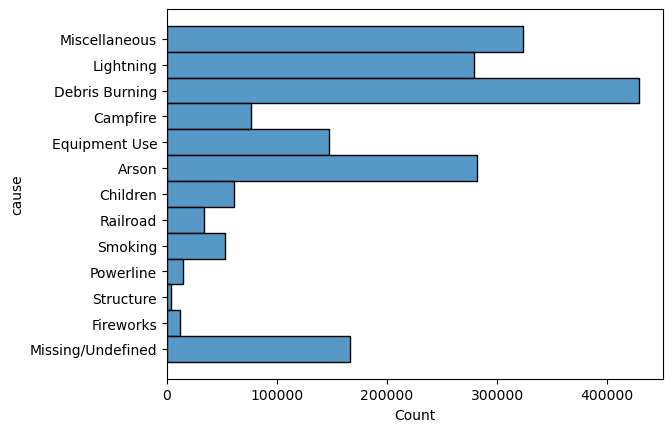

In [33]:
sns.histplot(fires, y = "cause")

In [72]:
mean_fire_size_state = pd.DataFrame({"mean": fires.groupby("state")["fire_size"].mean()})
std_fire_size_state = pd.DataFrame({"std": fires.groupby("state")["fire_size"].std()})
fire_size_state = mean_fire_size_state.merge(std_fire_size_state, how = "left", on = "state").reset_index().sort_values(by = "mean", ascending = False)
fire_size_state.head()


,state,mean,std
0,AK,2509.779198,19600.650646
33,NV,531.720650,5888.665139
13,ID,372.890482,5643.331940
32,NM,170.234318,2858.989052
51,WY,169.523555,2195.531021


In [29]:
fires_binary_copy = fires.copy()
fires_binary_copy = pd.get_dummies(fires_binary_copy, columns = ["state", "season"])
fires_binary_copy = fires_binary_copy.drop(["doy", "longitude", "latitude", "cause"], axis = 1)

In [28]:
fires_binary_copy = fires.copy()
fires_binary_copy = pd.get_dummies(fires_binary_copy, columns = ["state", "season"])
fires_binary_copy = fires_binary_copy.drop(["doy", "longitude", "latitude", "cause"], axis = 1)


X_train, X_test, y_train, y_test = train_test_split(fires_binary_copy.loc[:, fires_binary_copy.columns != "fire_size"],
                                                    fires_binary_copy["fire_size"], 
                                                    test_size = .3, shuffle = True)

tree = DecisionTreeRegressor()
parameters = np.power(np.linspace(-2, 10, 30), 2)
parameters = {"min_impurity_decrease": parameters}
kfcv = KFold()
cvgs = GridSearchCV(tree, parameters, cv = kfcv, n_jobs = -1)

cvgs.fit(X_train, y_train)



KeyboardInterrupt: 

In [124]:
cvgs.best_estimator_

DecisionTreeRegressor(min_impurity_decrease=103.22546966498338)

In [127]:
tree = DecisionTreeRegressor(min_impurity_decrease = 103.22546966)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
y_pred_train = tree.predict(X_train)

train_mse = mean_squared_error(y_train, y_pred_train)
test_mse = mean_squared_error(y_test, y_pred)

print(train_mse)
print(test_mse)

6279554.9561549
5292254.543684822


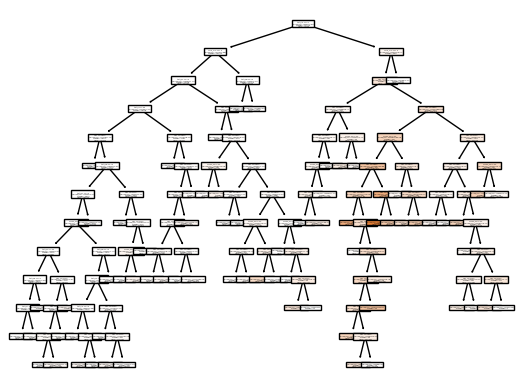

In [130]:
plot_tree(tree, filled = True, feature_names = X_train.columns)
plt.show()

In [133]:
np.sqrt(test_mse)

2300.490065982642

The Decision Tree model as it currently stands is predicting with an error of 2300 acres, which translates to approximately 3.9 square miles. That is actually not too bad of a prediction error on average. Lets now see how the decision tree does relative to some ensemble models such as random forest...

In [ ]:
random_forest = RandomForestRegressor()
#the goal here is to do kfold cross validation, and we want to search over what regularization parameter for minimum split impurity gives us the best accuracy.
# to find the best parameter, we use grid search, and to use grid search, we need to create a dictionary of parameters.
np.set_printoptions(precision=10, suppress=True)

X_train, X_test, y_train, y_test = train_test_split(fires_binary_copy.loc[:, fires_binary_copy.columns != "fire_size"],
                                                    fires_binary_copy["fire_size"], 
                                                    test_size = .3, shuffle = True)

parameters = {"min_impurity_decrease": np.power(np.linspace(.0001, 10, 30), 2)}
kfcv = KFold()
gscv = GridSearchCV(random_forest, parameters, cv = kfcv, n_jobs = -1)

gscv.fit(X_train, y_train)
gscv.best_estimator_